1. Introduction

This project explores Twitter activity data to understand user behavior and engagement patterns over time. Using MongoDB as the primary data store and Python for data processing, the notebook performs a complete workflow — from data extraction and cleaning to analysis and visualization.

The main objectives are:

-Integrate and prepare data from raw tweet and user collections stored in MongoDB.

-Clean and enrich the dataset, converting text-based timestamps into ISODate format and calculating new fields such as engagement rate and posting frequency.

-Validate data quality by checking for missing, null, or inconsistent values.

-Analyze tweet activity and engagement across different weekdays and hours to identify optimal posting times.

-Visualize patterns through heatmaps that highlight when users post most frequently and when audience interaction peaks.

Through this analysis, we aim to uncover when Twitter users are most active and when engagement is highest, providing actionable insights for improving visibility and interaction strategies on the platform.


2. Setup

First of all, we need to import our db files to Mongo. I will use Compass

![Connect](images/1.png)
![Connect](images/2.png)

Now, lets connect Mongo and visual studio.

In [2]:
from datetime import datetime, timezone
import pandas as pd
import pymongo
import matplotlib.pyplot as plt


#Connect to Mongo

client = pymongo.MongoClient(os.getenv("dbStringConnection"))

db = client["Twitter"]
tweets = db["tweets"]
accounts = db["twitterAccounts"]

3. Data preparation

In this stage, the raw data will be cleaned and enriched to make it more suitable for analysis. The goal is to transform the original tweet and account data into a structured, insightful dataset.
The created_at field from the tweets will be converted from string format (e.g. "Fri Apr 03 17:34:45 +0000 2020") into a proper ISODate. This allows for accurate sorting, filtering, and date calculations within MongoDB.

In [ ]:
# for t in tweets.find({}, {"_id": 1, "created_at": 1}):
#     try:
#         iso_date = datetime.strptime(t["created_at"], "%a %b %d %H:%M:%S %z %Y")
#         tweets.update_one({"_id": t["_id"]}, {"$set": {"created_at": iso_date}})
#     except Exception as e:
#         print("Error parsing:", t.get("created_at"), e)


This took a while as we are calling Mongo almost 12000. Let's try something different, but we need to get rid of week day (Mongo does not support it). It seems that the week day takes 3 characters in each date, but to be sure:

In [3]:
for d in tweets.aggregate([
    {"$project": {"prefix": {"$substr": ["$created_at", 0, 4]}}}, 
    {"$group": {"_id": "$prefix", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]):
    print(d)

{'_id': 'Thu ', 'count': 2199}
{'_id': 'Wed ', 'count': 2069}
{'_id': 'Fri ', 'count': 2035}
{'_id': 'Tue ', 'count': 1794}
{'_id': 'Mon ', 'count': 1761}
{'_id': 'Sat ', 'count': 1160}
{'_id': 'Sun ', 'count': 973}


In [4]:
tweets.update_many(
    {},
    [
        {
            "$set": {
                "created_at_iso": {
                    "$cond": [
                        { "$ifNull": ["$created_at", False] },
                        {
                            "$dateFromString": {
                                "dateString": {
                                    "$substrCP": [
                                        "$created_at",
                                        4,
                                        { "$subtract": [ { "$strLenCP": "$created_at" }, 4 ] }
                                    ]
                                },
                                "format": "%b %d %H:%M:%S %z %Y"
                            }
                        },
                        "$created_at"
                    ]
                }
            }
        }
    ]
)


UpdateResult({'n': 11991, 'electionId': ObjectId('7fffffff0000000000000047'), 'opTime': {'ts': Timestamp(1760544493, 1469), 't': 71}, 'nModified': 11991, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1760544493, 1469), 'signature': {'hash': b'\x86\x85;\xd1\r\xc9\xb78SSMCY\xfb\x14\x07\xec\xd9\x8c\xf3', 'keyId': 7497357158858620933}}, 'operationTime': Timestamp(1760544493, 1469), 'updatedExisting': True}, acknowledged=True)

Let's do the same with user creation date

In [5]:
tweets.update_many(
    {},
    [
        {
            "$set": {
                "user.created_at_iso": {
                    "$cond": [
                        { "$ifNull": ["$user.created_at", False] },
                        {
                            "$dateFromString": {
                                "dateString": { "$substr": ["$user.created_at", 4, -1] },
                                "format": "%b %d %H:%M:%S %z %Y"
                            }
                        },
                        "$user.created_at"
                    ]
                }
            }
        }
    ]
)

UpdateResult({'n': 11991, 'electionId': ObjectId('7fffffff0000000000000047'), 'opTime': {'ts': Timestamp(1760544518, 2409), 't': 71}, 'nModified': 11991, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1760544518, 2409), 'signature': {'hash': b'\xbb\xe6\xc8\x19\xb8\xd57\xe3j`.\xd2\x80t\x989\xa2\xf3&\xd2', 'keyId': 7497357158858620933}}, 'operationTime': Timestamp(1760544518, 2409), 'updatedExisting': True}, acknowledged=True)

We can add this info to twitterAccounts

In [12]:
for i in tweets.aggregate([
    {"$sort": {"user.screen_name": 1, "created_at_iso": -1}},
    {"$group": {
        "_id": "$user.screen_name",
        "created_at_iso": {"$first": "$user.created_at_iso"}
    }}
]):
    accounts.update_one(
        {"Twitter_handle": i["_id"]},
        {"$set": {"user_created_at_iso": i["created_at_iso"]}}
    )

If we check the tweets file, we can see that every account has a number of friends, but it does not appear on the accounts file, so let's add it. We will use the number of friends which appears in the most recent tweet of each account.

In [13]:
for i in tweets.aggregate([
    {"$sort": {"user.screen_name": 1, "created_at_iso": -1}},
    
    {"$group": {
        "_id": "$user.screen_name",
        "friends": {"$first": "$user.friends_count"}
    }}
]):
    accounts.update_one(
        {"Twitter_handle": i["_id"]},
        {"$set": {
            "friends": i["friends"]
        }}
    )

Now, let's aggregate earliest_tweet_in_db and number_of_tweets_in_db to Accounts, as these fields are empty

In [15]:
for i in tweets.aggregate([
    {"$group": {
        "_id": "$user.screen_name",
        "earliest_tweet_in_db": {"$min": "$created_at_iso"},
        "number_of_tweets_in_db": {"$sum": 1}
    }}
]):
    accounts.update_one(
        {"Twitter_handle": i["_id"]},
        {"$set": {
            "earliest_tweet_in_db": i["earliest_tweet_in_db"],
            "number_of_tweets_in_db": i["number_of_tweets_in_db"]
        }}
    )

We can check all this at Compass

![Connect](images/3.png)

We can easily check if some tweets or accounts don’t have certain key fields. Even if a field exists, sometimes it’s null or empty.

In [16]:
print("Tweets missing text:", tweets.count_documents({"text": {"$exists": False}}))
print("Tweets missing date:", tweets.count_documents({"created_at_iso": {"$exists": False}}))
print("Tweets missing user:", tweets.count_documents({"user": {"$exists": False}}))
print("Tweets with null text:", tweets.count_documents({"text": None}))
print("Tweets with empty text:", tweets.count_documents({"text": ""}))

Tweets missing text: 0
Tweets missing date: 0
Tweets missing user: 0
Tweets with null text: 0
Tweets with empty text: 0


favorite_count, retweet_count and followers_count should be positive and integer numbers

In [17]:
tweets_with_wrong_values = tweets.count_documents({
    "$or": [
        {"favorite_count": {"$not": {"$type": "int"}}},
        {"retweet_count": {"$not": {"$type": "int"}}},
        {"user.followers_count": {"$not": {"$type": "int"}}},
        {"favorite_count": {"$lt": 0}},
        {"retweet_count": {"$lt": 0}},
        {"user.followers_count": {"$lt": 0}}
    ]
})

print("Tweets with invalid numeric values:", tweets_with_wrong_values)

Tweets with invalid numeric values: 0


Finally, we will add the engagement rate of every tweet (rts+favs)/followers and how many tweets/day every user writes. Let's start with engagement rate

In [18]:
tweets.update_many(
    {},
    [
        {
            "$set": {
                "engagement_rate": {
                    "$cond": [
                        { "$gt": ["$user.followers_count", 1] },
                        {
                            "$divide": [
                                { "$add": ["$retweet_count", "$favorite_count"] },
                                "$user.followers_count"
                            ]
                        },
                        0
                    ]
                }
            }
        }
    ]
)

UpdateResult({'n': 11991, 'electionId': ObjectId('7fffffff0000000000000047'), 'opTime': {'ts': Timestamp(1760545139, 1371), 't': 71}, 'nModified': 11991, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1760545139, 1371), 'signature': {'hash': b'zJ\xa4?\xd4y\xaa\x1c\n\xb8@W\x15\xfc@\xff\x8aK\xf1\x1f', 'keyId': 7497357158858620933}}, 'operationTime': Timestamp(1760545139, 1371), 'updatedExisting': True}, acknowledged=True)

Posting frequency of every account per day

In [19]:
accounts.update_many(
    {},
    [
        {
            "$set": {
                "posting_frequency": {
                    "$let": {
                        "vars": {
                            "days_since": {
                                "$divide": [
                                    { "$subtract": ["$$NOW", "$earliest_tweet_in_db"] },
                                    1000 * 60 * 60 * 24
                                ]
                            }
                        },
                        "in": {
                            "$cond": [
                                { "$gt": ["$$days_since", 0] },
                                {
                                    "$divide": [
                                        "$number_of_tweets_in_db",
                                        "$$days_since"
                                    ]
                                },
                                0
                            ]
                        }
                    }
                }
            }
        }
    ]
)

UpdateResult({'n': 12, 'electionId': ObjectId('7fffffff0000000000000047'), 'opTime': {'ts': Timestamp(1760545142, 12), 't': 71}, 'nModified': 12, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1760545142, 12), 'signature': {'hash': b'\xb2\xad65\r_\x1a,\x18\x06\xd5\x9d\xdc\xdb;\x9d\xce\x14,\xe1', 'keyId': 7497357158858620933}}, 'operationTime': Timestamp(1760545142, 12), 'updatedExisting': True}, acknowledged=True)

4. Data Visualization and Data Analysis

We need to study what is the best time for posting at Twitter. First, I will compare how many followers each account has. I will use Mongo Charts.

Let's create a chart at MongoDB to see the number of friends of each account

![Connect](images/4.png)

We can observe that sanchezcastejon, unicomplutense, and AlejandroSanz have the highest numbers of friends among all analyzed accounts, while JuanLuisGuerra and RafaelNadal have comparatively fewer. This suggests different levels of network interaction or following behavior among the users studied. Then, we cannot compare directly the number of retweets and favorited between tweets, as there is a huge difference of followers. Let's use engagement.

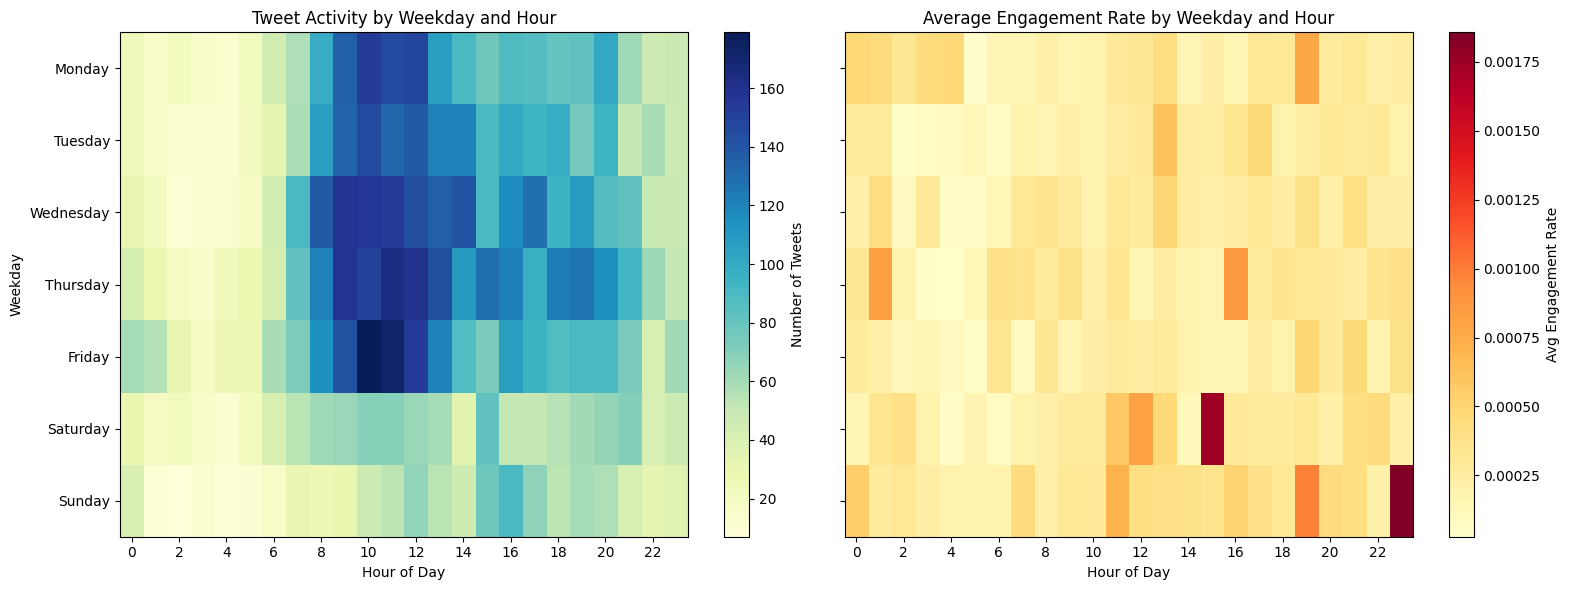

In [20]:
#Activity
activity_data = []
for doc in tweets.find({}, {"created_at_iso": 1}):
    dt = doc.get("created_at_iso")
    if isinstance(dt, datetime):
        activity_data.append({
            "weekday": dt.strftime("%A"),
            "hour": dt.hour
        })

df_activity = pd.DataFrame(activity_data)

pivot_activity = df_activity.pivot_table(
    index="weekday", columns="hour", aggfunc="size", fill_value=0
)

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot_activity = pivot_activity.reindex(weekday_order)


#Engagement
eng_data = []
for doc in tweets.find({}, {"created_at_iso": 1, "engagement_rate": 1}):
    dt = doc.get("created_at_iso")
    engagement = doc.get("engagement_rate", None)

    if isinstance(dt, datetime) and isinstance(engagement, (int, float)):
        eng_data.append({
            "weekday": dt.strftime("%A"),
            "hour": dt.hour,
            "engagement": engagement
        })

df_eng = pd.DataFrame(eng_data)

pivot_eng = df_eng.pivot_table(
    index="weekday",
    columns="hour",
    values="engagement",
    aggfunc="mean",
    fill_value=0
)
pivot_eng = pivot_eng.reindex(weekday_order)



fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#Left: Tweet Activity
im1 = axes[0].imshow(pivot_activity, cmap="YlGnBu", aspect="auto")
axes[0].set_title("Tweet Activity by Weekday and Hour")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Weekday")
axes[0].set_xticks(range(0, 24, 2))
axes[0].set_xticklabels(range(0, 24, 2))
axes[0].set_yticks(range(7))
axes[0].set_yticklabels(pivot_activity.index)
fig.colorbar(im1, ax=axes[0], label="Number of Tweets")

#Right: Average Engagement Rate
im2 = axes[1].imshow(pivot_eng, cmap="YlOrRd", aspect="auto")
axes[1].set_title("Average Engagement Rate by Weekday and Hour")
axes[1].set_xlabel("Hour of Day")
axes[1].set_xticks(range(0, 24, 2))
axes[1].set_xticklabels(range(0, 24, 2))
fig.colorbar(im2, ax=axes[1], label="Avg Engagement Rate")

plt.tight_layout()
plt.show()


While weekday mornings are the most active posting period, the audience appears more responsive during less saturated times, such as weekends and later hours of the day.

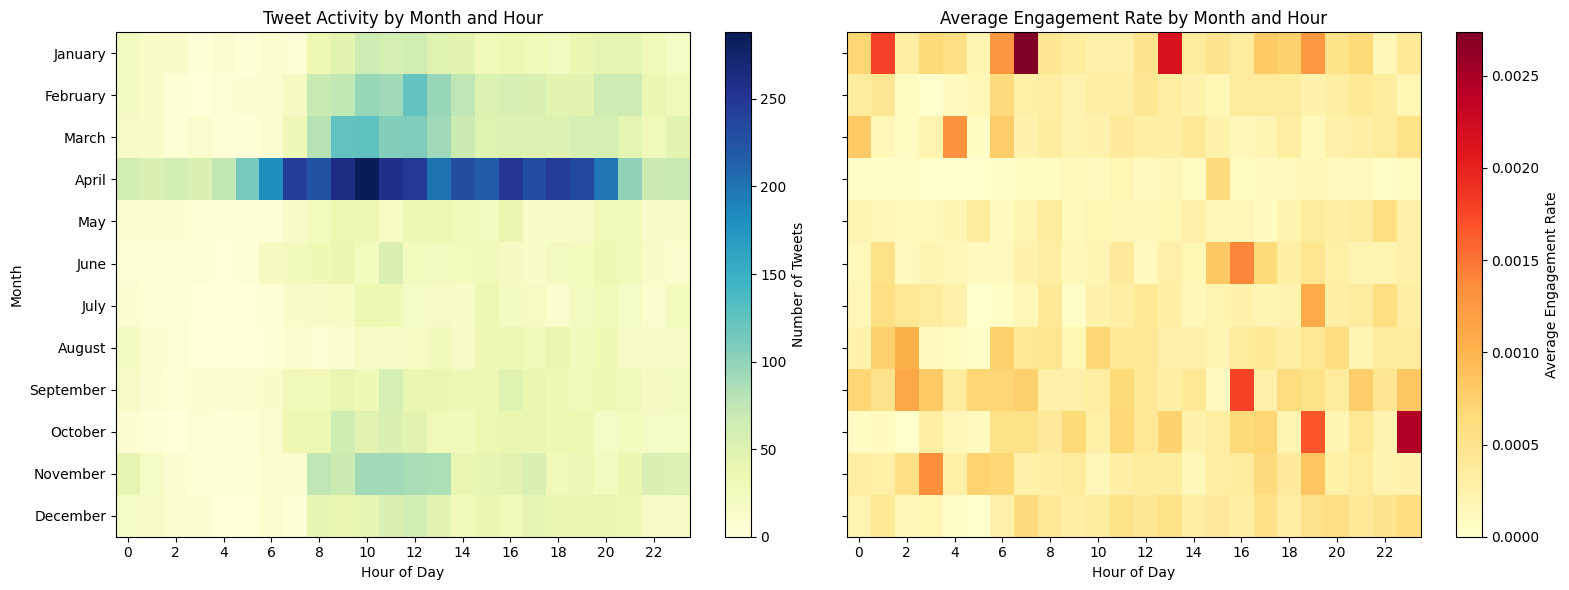

In [21]:
#Activity
activity_data = []
for doc in tweets.find({}, {"created_at_iso": 1}):
    dt = doc.get("created_at_iso")
    if isinstance(dt, datetime):
        activity_data.append({
            "month": dt.strftime("%B"),
            "hour": dt.hour
        })
df_activity = pd.DataFrame(activity_data)

pivot_activity = df_activity.pivot_table(
    index="month", columns="hour", aggfunc="size", fill_value=0
)

month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
pivot_activity = pivot_activity.reindex(month_order)

#Engagement
eng_data = []
for doc in tweets.find({}, {"created_at_iso": 1, "engagement_rate": 1}):
    dt = doc.get("created_at_iso")
    engagement = doc.get("engagement_rate", 0)
    if isinstance(dt, datetime):
        eng_data.append({
            "month": dt.strftime("%B"),
            "hour": dt.hour,
            "engagement": engagement
        })
df_eng = pd.DataFrame(eng_data)

pivot_eng = df_eng.pivot_table(
    index="month", columns="hour", values="engagement", aggfunc="mean", fill_value=0
)
pivot_eng = pivot_eng.reindex(month_order)


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#Left: Tweet Activity
im1 = axes[0].imshow(pivot_activity, cmap="YlGnBu", aspect="auto")
axes[0].set_title("Tweet Activity by Month and Hour")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Month")
axes[0].set_xticks(range(0, 24, 2))
axes[0].set_xticklabels(range(0, 24, 2))
axes[0].set_yticks(range(12))
axes[0].set_yticklabels(pivot_activity.index)
fig.colorbar(im1, ax=axes[0], label="Number of Tweets")

#Right: Average Engagement Rate
im2 = axes[1].imshow(pivot_eng, cmap="YlOrRd", aspect="auto")
axes[1].set_title("Average Engagement Rate by Month and Hour")
axes[1].set_xlabel("Hour of Day")
axes[1].set_xticks(range(0, 24, 2))
axes[1].set_xticklabels(range(0, 24, 2))
fig.colorbar(im2, ax=axes[1], label="Average Engagement Rate")

plt.tight_layout()
plt.show()


April’s high posting density coincides with low engagement rates, suggesting audience saturation. In contrast, months with fewer tweets often show higher relative engagement, implying better efficiency.

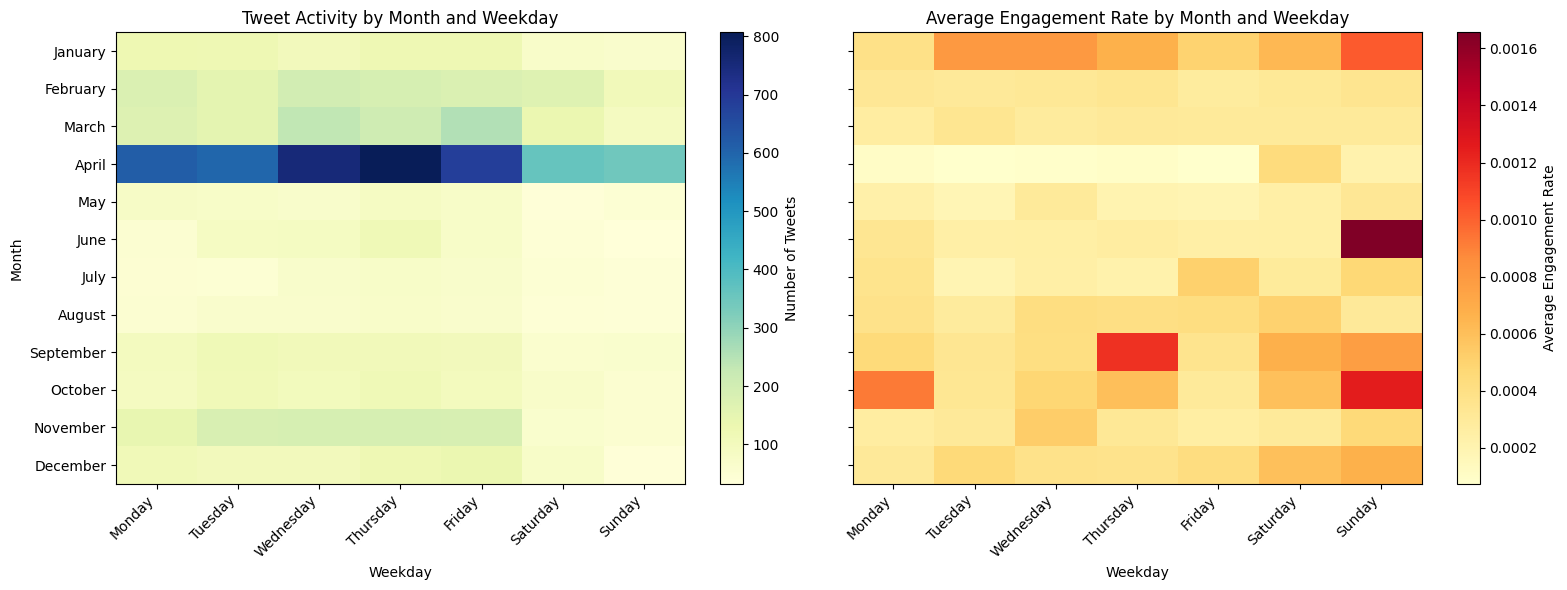

In [22]:
#Activity
activity_data = []
for doc in tweets.find({}, {"created_at_iso": 1}):
    dt = doc.get("created_at_iso")
    if isinstance(dt, datetime):
        activity_data.append({
            "month": dt.strftime("%B"),
            "weekday": dt.strftime("%A")
        })
df_activity = pd.DataFrame(activity_data)

pivot_activity = df_activity.pivot_table(
    index="month", columns="weekday", aggfunc="size", fill_value=0
)

month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

pivot_activity = pivot_activity.reindex(index=month_order, columns=weekday_order)

#Engagement
eng_data = []
for doc in tweets.find({}, {"created_at_iso": 1, "engagement_rate": 1}):
    dt = doc.get("created_at_iso")
    engagement = doc.get("engagement_rate", 0)
    if isinstance(dt, datetime):
        eng_data.append({
            "month": dt.strftime("%B"),
            "weekday": dt.strftime("%A"),
            "engagement": engagement
        })
df_eng = pd.DataFrame(eng_data)

pivot_eng = df_eng.pivot_table(
    index="month", columns="weekday", values="engagement", aggfunc="mean", fill_value=0
)
pivot_eng = pivot_eng.reindex(index=month_order, columns=weekday_order)


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#Left: Tweet Activity
im1 = axes[0].imshow(pivot_activity, cmap="YlGnBu", aspect="auto")
axes[0].set_title("Tweet Activity by Month and Weekday")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Month")
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(weekday_order, rotation=45, ha="right")
axes[0].set_yticks(range(12))
axes[0].set_yticklabels(pivot_activity.index)
fig.colorbar(im1, ax=axes[0], label="Number of Tweets")

#Right: Average Engagement Rate
im2 = axes[1].imshow(pivot_eng, cmap="YlOrRd", aspect="auto")
axes[1].set_title("Average Engagement Rate by Month and Weekday")
axes[1].set_xlabel("Weekday")
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(weekday_order, rotation=45, ha="right")
fig.colorbar(im2, ax=axes[1], label="Average Engagement Rate")

plt.tight_layout()
plt.show()


Engagement increases when the account posts less frequently, particularly on weekends. Reduced posting volume appears to enhance visibility and user interaction.

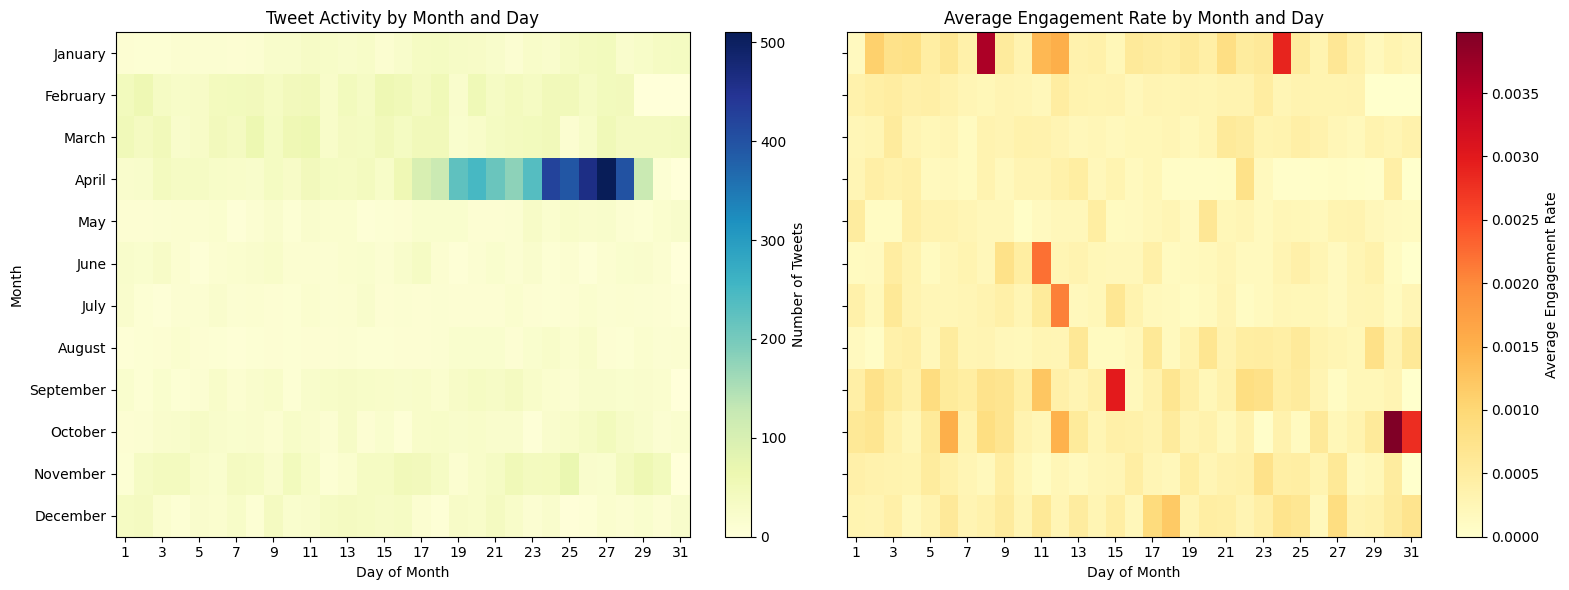

In [23]:
#Activity
activity_data = []
for doc in tweets.find({}, {"created_at_iso": 1}):
    dt = doc.get("created_at_iso")
    if isinstance(dt, datetime):
        activity_data.append({
            "month": dt.strftime("%B"),
            "day": dt.day
        })
df_activity = pd.DataFrame(activity_data)

pivot_activity = df_activity.pivot_table(
    index="month", columns="day", aggfunc="size", fill_value=0
)

month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
pivot_activity = pivot_activity.reindex(month_order)

#Engagement
eng_data = []
for doc in tweets.find({}, {"created_at_iso": 1, "engagement_rate": 1}):
    dt = doc.get("created_at_iso")
    engagement = doc.get("engagement_rate", 0)
    if isinstance(dt, datetime):
        eng_data.append({
            "month": dt.strftime("%B"),
            "day": dt.day,
            "engagement": engagement
        })
df_eng = pd.DataFrame(eng_data)

pivot_eng = df_eng.pivot_table(
    index="month", columns="day", values="engagement", aggfunc="mean", fill_value=0
)
pivot_eng = pivot_eng.reindex(month_order)


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#Left plot: Tweet Activity
im1 = axes[0].imshow(pivot_activity, cmap="YlGnBu", aspect="auto")
axes[0].set_title("Tweet Activity by Month and Day")
axes[0].set_xlabel("Day of Month")
axes[0].set_ylabel("Month")
axes[0].set_xticks(range(0, 31, 2))
axes[0].set_xticklabels(range(1, 32, 2))
axes[0].set_yticks(range(12))
axes[0].set_yticklabels(pivot_activity.index)
fig.colorbar(im1, ax=axes[0], label="Number of Tweets")

#Right plot: Engagement Rate
im2 = axes[1].imshow(pivot_eng, cmap="YlOrRd", aspect="auto")
axes[1].set_title("Average Engagement Rate by Month and Day")
axes[1].set_xlabel("Day of Month")
axes[1].set_xticks(range(0, 31, 2))
axes[1].set_xticklabels(range(1, 32, 2))
fig.colorbar(im2, ax=axes[1], label="Average Engagement Rate")

plt.tight_layout()
plt.show()


We see distinct engagement peaks on specific dates, such as after the Christmas holidays and around Halloween.

There is a clear inverse relationship between tweet volume and engagement rate: more tweets do not necessarily mean more engagement. When posting frequency increase, the average engagement rate tends to drop.

Engagement performs best:

-On weekends, when fewer tweets are published.

-During off-peak hours (afternoons and evenings).

-In months with lower posting activity, which likely face less competition for attention.

5. Conclusions

1-Avoid over-concentrating campaigns in a single month (like April). Sustained activity may yield better long-term results.

2-Post lighter, visual, or emotionally engaging content on Saturdays and Sundays, when engagement rates are higher.

3-Experiment with alternative posting times. Test later hours (18:00–22:00), when audience availability is higher and feed competition is lower.